# confusion matrix & umaps

In [1]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from pathlib import Path
import anndata

def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, ax=None
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = [6, 4]
    # print(classes)
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    if ax is None:
        (fig, ax) = plt.subplots()

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return fig, ax

In [2]:
paths = [
    Path("../out/lambrechts/"),
    Path("../out/kildisiute_10x/"),
    Path("../out/kildisiute_celseq2/"),
    Path("../out/tirosh/")
]
names = [
    "lambrechts",
    "kildisiute_10x",
    "kildisiute_celseq2",
    "tirosh"
]

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     45251
       Tumor       0.95      0.95      0.95      7447

    accuracy                           0.99     52698
   macro avg       0.97      0.97      0.97     52698
weighted avg       0.99      0.99      0.99     52698



/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tier_0_pred_correctness' as categorical


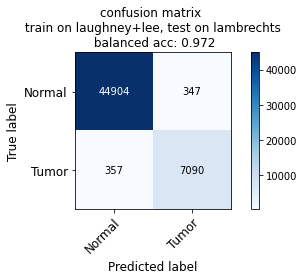

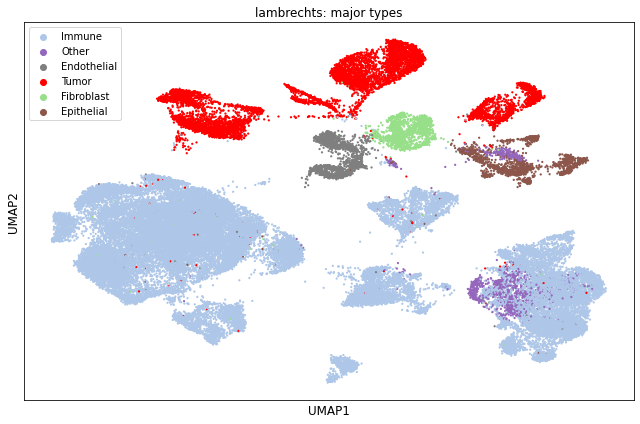

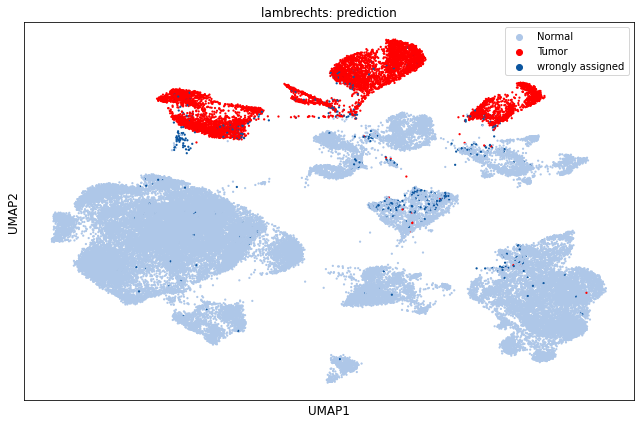

/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tier_0_pred_correctness' as categorical


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      4676
       Tumor       1.00      1.00      1.00      1766

    accuracy                           1.00      6442
   macro avg       1.00      1.00      1.00      6442
weighted avg       1.00      1.00      1.00      6442



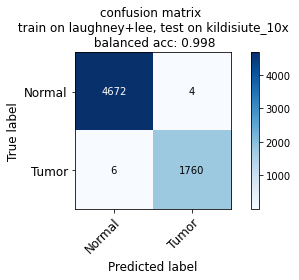

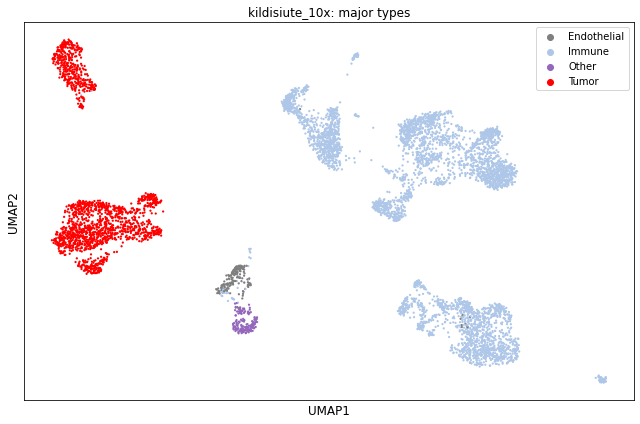

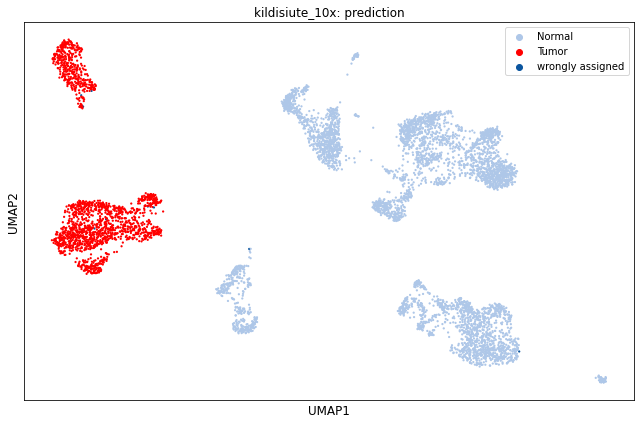

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     11651
       Tumor       0.98      0.97      0.97      1630

    accuracy                           0.99     13281
   macro avg       0.99      0.98      0.99     13281
weighted avg       0.99      0.99      0.99     13281



/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tier_0_pred_correctness' as categorical


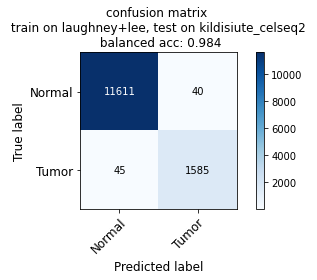

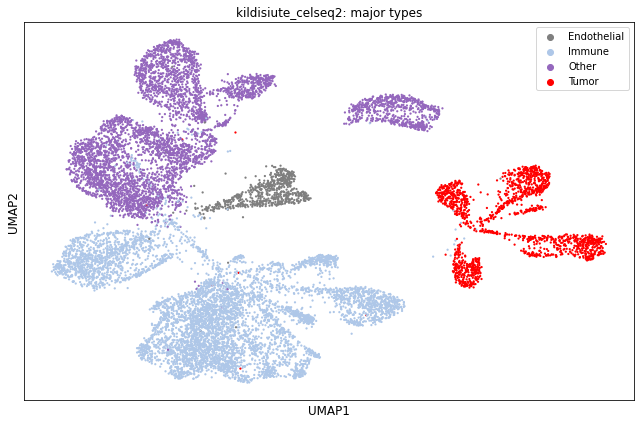

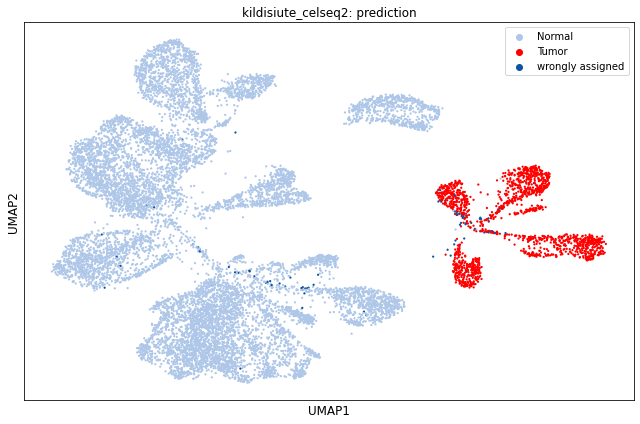

/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tier_0_pred_correctness' as categorical


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      3363
       Tumor       1.00      1.00      1.00      2215

    accuracy                           1.00      5578
   macro avg       1.00      1.00      1.00      5578
weighted avg       1.00      1.00      1.00      5578



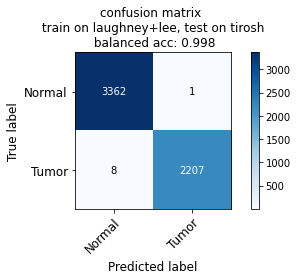

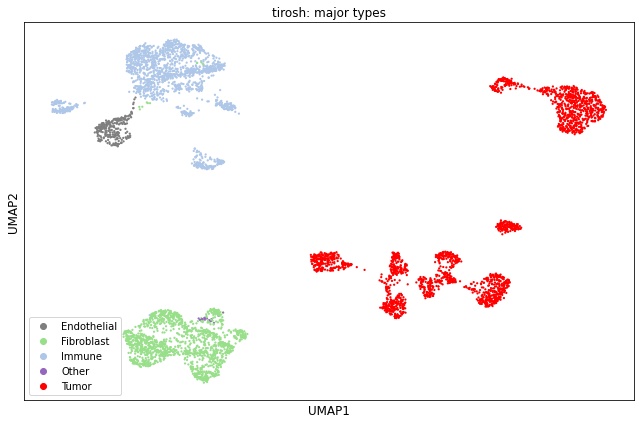

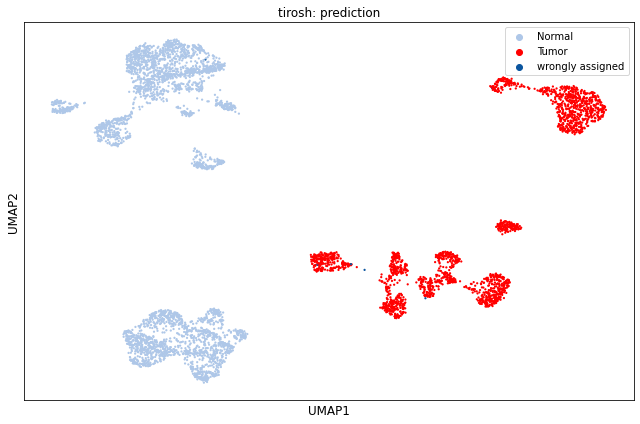

In [3]:
for path, name in zip(paths, names):
    results = pd.read_csv(path / "prediction.csv", index_col=0)
    adata = anndata.read_h5ad(path / "adata_umap.h5ad")

    y = adata.obs.loc[:, 'tier_0']
    y_pred_lr = results['final_pred']
    acc = metrics.balanced_accuracy_score(y, y_pred_lr)
    print(metrics.classification_report(y, y_pred_lr, labels=['Normal', 'Tumor']))
    fig, ax = plot_confusion_matrix(
        y,
        y_pred_lr,
        classes=['Normal', 'Tumor'],
        title=f'confusion matrix \n train on laughney+lee, test on {name} \n balanced acc: {acc:.3f}',
    )
    fig.tight_layout()
    fig.savefig(f"F2_{name}_confusion_matrix.pdf")

    
    # umaps
    adata.obs.loc[:, 'tier_0_pred_correctness'] = 'wrongly assigned'
    adata.obs.loc[
        adata.obs['tier_0'] == adata.obs['final_pred'],
        'tier_0_pred_correctness'
    ] = 'correctly assigned'
    adata.obs.loc[:, 'tier_0_pred_wrong'] = pd.Categorical(
        adata.obs['tier_0'].copy(),
        categories=np.array(['Normal', 'Tumor', 'wrongly assigned']),
        ordered=True
    )
    adata.obs.loc[
        adata.obs['tier_0_pred_correctness'] == 'wrongly assigned',
        'tier_0_pred_wrong'
    ] = 'wrongly assigned'

    plt.rcParams['figure.figsize'] = [9, 6]

    colors = [
        ['major'],
        ['tier_0_pred_wrong']
        ]
    titles = [
        [f'{name}: major types'],
        [f'{name}: prediction']
        ]
    palettes = [
        [],
        ['#aec7e8', '#ff0000', '#0b559f'], 
    ]

    if name == 'lambrechts':
        palettes[0] = ['#aec7e8', '#9467bd', '#7f7f7f', '#ff0000', '#98df8a', '#8c564b']
        categories = adata.obs['major'].unique().replace('nan', 'Other').to_list()
        adata.obs['major'] = pd.Categorical(adata.obs['major'], categories=categories, ordered=True)
        adata.obs['major'].loc[adata.obs['major'].isna()] = 'Other'
    elif name == 'kildisiute_10x':
        palettes[0] = ['#7f7f7f', '#aec7e8', '#9467bd', '#ff0000']
    elif name == 'kildisiute_celseq2':
        palettes[0] = ['#7f7f7f', '#aec7e8', '#9467bd', '#ff0000']
    elif name == 'tirosh':
        palettes[0] = ['#7f7f7f', '#98df8a', '#aec7e8', '#9467bd', '#ff0000']
    else:
        raise(print(f'Error: Palette for {test_name} is not defined.'))

    for color, title, palette, umap_type in zip(colors, titles, palettes, ["major_types", "prediction"]):

        ax = sc.pl.umap(
            adata, ncols=1, size=20, 
            color=color,
            title=title,
            wspace=0.25,
            vmax='p99',
            legend_fontsize=12,
            palette=palette,
            show=False
        )
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(12)
        ax.legend(loc='best')
        plt.tight_layout()
        plt.savefig(f"F2_{name}_{umap_type}_umaps.pdf")
        plt.show()

# comparison to reference methods

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [12]:
df = pd.read_csv("../out/prediction_reference_classifier.csv")

In [13]:
df

,method,dataset,AUROC,bal. accuracy,avg. precision
0,LR,lambrechts,0.791345,0.667504,0.521693
1,RF,lambrechts,0.789335,0.573553,0.483382
2,SVM,lambrechts,0.808649,0.675565,0.546348
3,LR \n Label prop.,lambrechts,0.973953,0.615584,0.903628
4,RF \n Label prop.,lambrechts,0.897588,0.500134,0.721613
5,"ikarus: \n laughney, lee input",lambrechts,0.989206,0.971621,0.976503
6,LR,kildisiute_10x,0.798550,0.701837,0.535126
7,RF,kildisiute_10x,0.922381,0.519417,0.739914
8,SVM,kildisiute_10x,0.833513,0.701114,0.623638
9,LR \n Label prop.,kildisiute_10x,0.960249,0.693755,0.875249


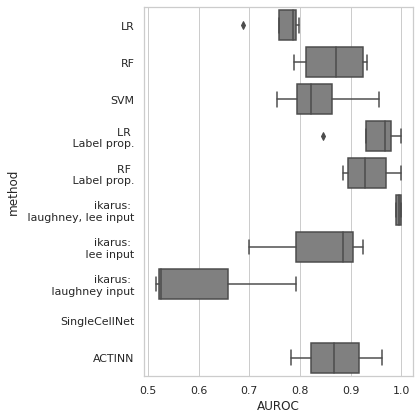

In [14]:
sns.set_theme(style='whitegrid')
ax = plt.figure(figsize=[6, 6])
ax = sns.boxplot(y="method", x="AUROC", data=df, color="0.5")
plt.tight_layout()
ax.get_figure().savefig('F2_reference_methods_AUROC_box.pdf')

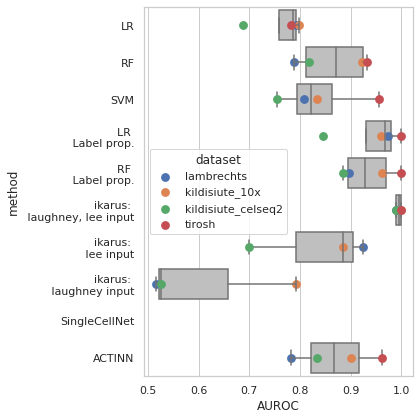

In [15]:
sns.set_theme(style='whitegrid')
ax = plt.figure(figsize=[6, 6])
ax = sns.pointplot(y="method", x="AUROC", hue="dataset", data=df, join=False)
ax = sns.boxplot(y="method", x="AUROC", data=df, color="0.75")
plt.tight_layout()
ax.get_figure().savefig('F2_reference_methods_AUROC_box_point.pdf')

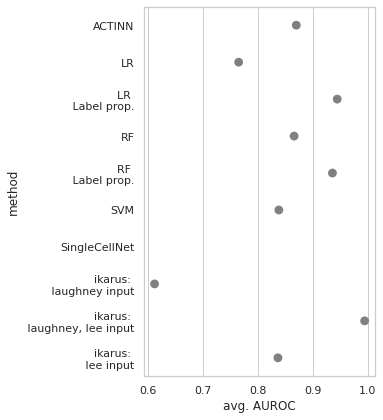

In [29]:
sns.set_theme(style='whitegrid')
ax = plt.figure(figsize=[5.5, 6])
mean_df = df.groupby(['method'])['AUROC'].agg(['mean']).reset_index()
mean_df.columns = ['method', "avg. AUROC"]
ax = sns.pointplot(y="method", x="avg. AUROC", data=mean_df, color='0.5', join=False)
plt.tight_layout()
ax.get_figure().savefig('F2_reference_methods_AUROC_mean_point.pdf')

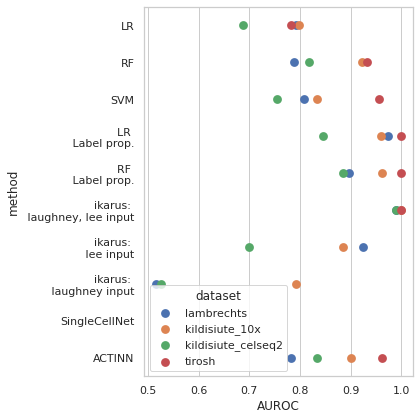

In [17]:
sns.set_theme(style='whitegrid')
ax = plt.figure(figsize=[6, 6])
ax = sns.pointplot(y="method", x="AUROC", hue="dataset", data=df, join=False)
plt.tight_layout()
ax.get_figure().savefig('F2_reference_methods_AUROC_point.pdf')

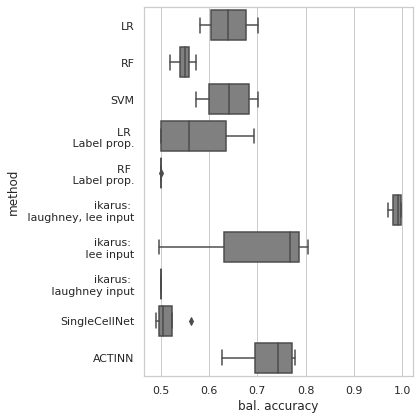

In [27]:
sns.set_theme(style='whitegrid')
ax = plt.figure(figsize=[6, 6])
ax = sns.boxplot(y="method", x="bal. accuracy", data=df, color="0.5")
plt.tight_layout()
ax.get_figure().savefig('F2_reference_methods_balacc_box.pdf')

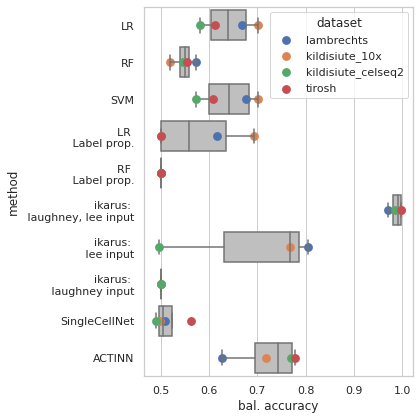

In [19]:
sns.set_theme(style='whitegrid')
ax = plt.figure(figsize=[6, 6])
ax = sns.pointplot(y="method", x="bal. accuracy", hue="dataset", data=df, join=False)
ax = sns.boxplot(y="method", x="bal. accuracy", data=df, color="0.75")
plt.tight_layout()
ax.get_figure().savefig('F2_reference_methods_balacc_box_point.pdf')

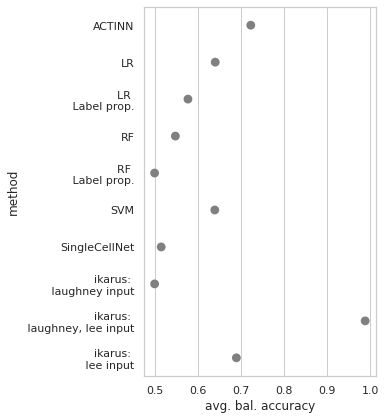

In [23]:
sns.set_theme(style='whitegrid')
ax = plt.figure(figsize=[5.5, 6])
mean_df = df.groupby(['method'])['bal. accuracy'].agg(['mean']).reset_index()
mean_df.columns = ['method', "avg. bal. accuracy"]
ax = sns.pointplot(y="method", x="avg. bal. accuracy", data=mean_df, color='0.5', join=False)
plt.tight_layout()
ax.get_figure().savefig('F2_reference_methods_balacc_mean_point.pdf')

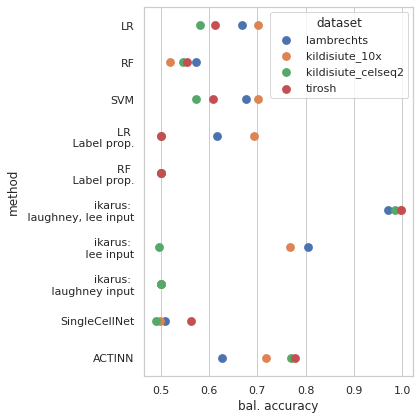

In [25]:
sns.set_theme(style='whitegrid')
ax = plt.figure(figsize=[6, 6])
ax = sns.pointplot(y="method", x="bal. accuracy", hue="dataset", data=df, join=False)
plt.tight_layout()
ax.get_figure().savefig('F2_reference_methods_balacc_point.pdf')